In [7]:
using BenchmarkTools
include("../src/MyUnits.jl")

x_arr = 10 .^ (range(-2, stop=2, length=50))

function f(x::Array, y::Real)
    x .+ y
end

function f(x::Array, y::Array)
    x + y
end

f (generic function with 2 methods)

In [1]:
using BenchmarkTools
using Unitful

import Unitful: DimensionlessQuantity, Temperature

abstract type Patate end

struct Example{T<:Real} <: Patate
    a::DimensionlessQuantity{T}
    c::DimensionlessQuantity{T}
    b::Temperature{T}
end

struct Example2{T<:Real} <: Patate
    a::T
    b::T
    c::T
end

struct Example3{T<:Real} <: Patate
    a::T
    b::Temperature{T}
    c::T
end


function Example(a::Real, b::Real, c::Temperature{<:Real}) 
    return Example(promote(a, b, c)...)
end 

Example2(a::Real, b::Real, c::Real) = Example2(promote(a, b, c)...)

ex  = Example(2.3, 4//2,  4u"K")
ex2 = Example2(2.3, 4, 4//2)
ex3 = Example3(2.3, 4.0u"K", 2.0)


function mult(p::Patate)
    return p.a * p.c
end

@derived_dimension Mode dimension(1/u"km")
power_law(amplitude::Real, index::Real, k::Mode{<:Real}) = amplitude * (k / 0.05 * Mpc)^(index-1) ## To be checked

println(typeof(power_law))

typeof(power_law)


In [28]:
using BenchmarkTools

using Unitful
import Unitful: km, s, Gyr
using UnitfulAstro: Mpc, Gpc, Msun, kpc

include("../src/MyCosmology.jl")
include("../src/PowerSpectrum.jl")
#include("../src/TransferFunction.jl")

import .MyCosmology: FLRWPLANCK18


In [3]:
#@benchmark cosmo = MyCosmology.FlatFLRW(0.6736, 0.26447, 0.04930)
PowerSpectrum.curvature_power_spectrum(0.2/Mpc)

4.9328720557107265e-6 Mpc³

0.31377 9.21221186221331e-5 0.6861378778813779


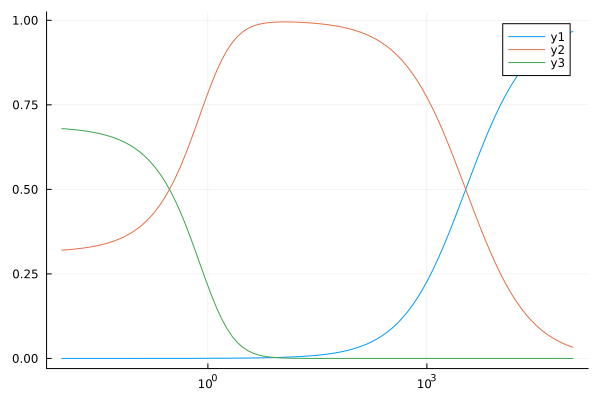

In [2]:
using Plots

z = 10 .^(range(-2,stop=5,length=100))

println(FLRWPLANCK18.Ω_m0, " ", FLRWPLANCK18.Ω_r0, " ", FLRWPLANCK18.Ω_Λ0)

Ω_r = MyCosmology.ρ_r.(z) ./ MyCosmology.ρ_c.(z)
Ω_m = MyCosmology.Ω_m.(z)
Ω_Λ = MyCosmology.Ω_Λ.(z)

ρ_r = MyCosmology.ρ_r.(z)
ρ_m = MyCosmology.ρ_m.(z)
ρ_Λ = MyCosmology.ρ_Λ.(z)
ρ_c = MyCosmology.ρ_c.(z)

plot(z, Ω_r)
plot!(z, Ω_m)
plot!(z, Ω_Λ)


plot!(size=(600, 400), xscale=:log10,  minorgrid=false)


In [29]:
using BenchmarkTools
include("../src/Halos.jl")

Halos.cΔ_from_ρs(10 * Msun / kpc^3)
Halos.ρs_from_cΔ(10)

UndefVarError: UndefVarError: kpc not defined

In [13]:
using NLsolve
using BenchmarkTools

function f!(F, x)
    F[1] = (x[1]+3)*(x[2]^3-7)+18
    F[2] = sin(x[2]*exp(x[1])-1)
end

function j!(J, x)
    J[1, 1] = x[2]^3-7
    J[1, 2] = 3*x[2]^2*(x[1]+3)
    u = exp(x[1])*cos(x[2]*exp(x[1])-1)
    J[2, 1] = x[2]*u
    J[2, 2] = u
end

nlsolve(f!, j!, [ 0.1; 1.2])
println(nlsolve(f!, [ 0.1; 1.2]))

func(x, y) = ((x+3)*(y^3-7)+18, sin(y*exp(x)-1))
println(func(0, 1))

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.1, 1.2]
 * Zero: [-2.758597248806451e-16, 1.0000000000000002]
 * Inf-norm of residuals: 0.000000
 * Iterations: 4
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 5
 * Jacobian Calls (df/dx): 5


(0, 0.0)


In [63]:
using Unitful
import Unitful: km, s, Gyr, rad
import UnitfulAstro: Mpc, Gpc, Msun, kpc, pc

D1 = 3.0 
D2 = 6.0 
DS = 8.0 

M1 = 100.0
M2 = 100.0

# For the first test let us imagine everything is in the same plane

y1 = [1e-8, 0.] 
y2 = [0, 1e-8] 

function alpha(x, y, M)
    return 4 .* M * (x .- y) ./ sum((x .- y) .* (x .- y)) * 4.3e-6 / (3e+6)^2  
end

function f!(F, x)
    F[1] = x[1] -  D1 * (1. - D1/DS) * alpha([x[1], x[2]], y1, M1)[1] + D1 * (1. - D2/DS)*alpha([x[3], x[4]], y2, M2)[1]
    F[2] = x[2] -  D1 * (1. - D1/DS) * alpha([x[1], x[2]], y1, M1)[2] + D1 * (1. - D2/DS)*alpha([x[3], x[4]], y2, M2)[2]
    F[3] = x[3] -  D2 * (D1/D2 - D2/DS) * alpha([x[1], x[2]], y1, M1)[1] + D2 * (1. - D2/DS)*alpha([x[3], x[4]], y2, M2)[1]
    F[4] = x[4] -  D2 * (D1/D2 - D2/DS) * alpha([x[1], x[2]], y1, M1)[2] + D2 * (1. - D2/DS)*alpha([x[3], x[4]], y2, M2)[2]
end

function theta(x, D1)
    return x[1:2] ./ D1 * 206265e+6
end

res = nlsolve(f!, [0., 0., 0., 0.]).zero

println(theta(res, D1))


[-830.9420861094994, 140.36767001971612]
